In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=f2ca52bca748c28b672d440867086387a06522da6166e52f7c98bd6228420820
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# import the necessary packages

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd 


# Buliding dataset

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
imagePaths = (  list(paths.list_images('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train')) 
              + list(paths.list_images('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'))
              + list(paths.list_images('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test')) ) 

In [5]:
labels = [] 
image_paths = []
for path in imagePaths : 
    label = path.split('/')[-2] 
    
    if label == 'WithMask' : 
        labels.append(1)
    else : 
        labels.append(0)
        
    image_paths.append(path)
    
data = pd.DataFrame(data = {'path' : image_paths , 'target' : labels})

In [6]:
train , valid = train_test_split(data , test_size = 0.2 , stratify = data.target , random_state = 42 )

In [7]:
data.target.mean()

0.4988975576662144

In [8]:
train.target.mean()

0.4988868864624192

In [9]:
train.head()

,path,target
3131,../input/face-mask-12k-images-dataset/Face Mas...,0
11696,../input/face-mask-12k-images-dataset/Face Mas...,1
2134,../input/face-mask-12k-images-dataset/Face Mas...,0
9811,../input/face-mask-12k-images-dataset/Face Mas...,1
7963,../input/face-mask-12k-images-dataset/Face Mas...,1


# Model class and Engine 

In [10]:
import numpy as np 
import pandas as pd 

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A

from PIL  import Image 

class MaskFaceDetectionDataset() : 
  def __init__(self , data , resize_to = (224,224) ,  is_train = True ) : 
    self.image_path   = data.path.values 
    self.target = data.target.values 
    
    if is_train : 
      train_transform = [
                          A.ShiftScaleRotate(shift_limit=0.0625,scale_limit=0.1,rotate_limit=5,p=0.9),
                          A.GridDistortion(p=0.5),
                          A.Resize(resize_to[0] , resize_to[1] , p = 1.0 ),
                          A.Normalize(
                              mean=[0.485],
                              std=[0.229],
                              max_pixel_value=255.0,
                              p=1.0,
                          ),
        
                        ]
      self.aug = A.Compose(train_transform , p = 1 )
    else : 
      self.aug = A.Compose(
                              [
                                  A.Resize(resize_to[0], resize_to[1], p= 1.0),
                                  A.Normalize(
                                      mean=[0.485],
                                      std=[0.229],
                                      max_pixel_value=255.0,
                                      p=1.0,
                                  ),
                              ],
                              p=1.0,
                          )
  def __len__(self) : 
    return  len(self.target)
    
  def __getitem__( self , item ) : 
    out = dict() 

    image = Image.open(self.image_path[item]) 
    image = self.aug(image  = np.array(image))['image']
    image = np.transpose(image , (2,0,1)).astype(float)
    out['image'] = torch.tensor(image , dtype = torch.float)
    out['target'] = torch.tensor(self.target[item] , dtype = torch.long) 
 

    return out 

In [11]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 2.9 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
from facenet_pytorch import InceptionResnetV1

import torch.nn as nn 
from torch.nn import functional as F

class FaceNet(nn.Module)  : 
  def __init__(self, pretrained = True ) : 
    super(FaceNet,self).__init__() 
    if pretrained : 
      self.model = InceptionResnetV1(classify=True, num_classes =1 , pretrained='vggface2')
    else : 
      self.model = InceptionResnetV1(classify=True,  num_classes =1 ,pretrained=None) 
      
  def forward(self,x) : 
    return self.model(x)  

In [13]:
import gc
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import accuracy_score

from torch.cuda import amp
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup


class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def loss_fn(outputs, targets) : 
    return nn.BCEWithLogitsLoss()(outputs , targets.view(-1,1) )
def train_fn(
    data_loader, model, loss_fn, optimizer, device, verbose, epoch ):
    """
    computes the model training for one epoch
    """
    model.train()
    tr_loss = 0
    counter = 0
    if verbose:
        losses = AverageMeter()
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else:
        tk0 = enumerate(data_loader)
    for bi, d in tk0:
        targets = d["target"].to(device , dtype = torch.float)
        images  = d["image"].to(device , dtype = torch.float)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        tr_loss += loss.item()
        counter += 1
        loss.backward()
        optimizer.step()
        if verbose:
            losses.update(loss.item(), targets.size(0))
            tk0.set_postfix(loss=losses.avg)
    return tr_loss / counter


def eval_fn(data_loader, model, loss_fn, device, verbose, epoch):
    """
    computes the model evaluation for one epoch
    """
    model.eval()
    fin_loss = 0
    counter = 0
    if verbose:
        losses = AverageMeter()
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else:
        tk0 = enumerate(data_loader)

    with torch.no_grad():
        for bi, d in tk0:
            targets = d["target"].to(device , dtype = torch.float)
            images  = d["image"].to(device  , dtype = torch.float)
            
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            fin_loss += loss.item()
            counter += 1
            if verbose:
                losses.update(loss.item(), targets.size(0))
                tk0.set_postfix(loss=losses.avg)
        return fin_loss / counter


def run(
    model,
    train_dataset,
    valid_dataset,
    loss_fn,
    lr,
    EPOCHS,
    TRAIN_BATCH_SIZE,
    VALID_BATCH_SIZE,
    device,
    path,
    verbose=True,
):
    """
    trains a given model for a given number of epochs and paramters
    """
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE, num_workers=4
    )
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=4, shuffle=False
    )
    num_train_steps = int(len(train_data_loader)) * EPOCHS
    optimizer = AdamW(model.parameters(), lr=lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.2, patience=3, verbose=verbose
    )
    train_loss = []
    val_loss = []
    best = 50000
    patience = 0
    for epoch in range(EPOCHS):
        if verbose:
            print(f"--------- Epoch {epoch} ---------")
        tr_loss = train_fn(
            train_data_loader,
            model,
            loss_fn,
            optimizer,
            device,
            verbose,
            epoch,       
        )
        train_loss.append(tr_loss)
        
        if verbose:
            print(f" train_loss  = {tr_loss}")
        val = eval_fn(
            valid_data_loader, model, loss_fn, device, verbose, epoch
        )
        
        val_loss.append(val)
        scheduler.step(val)

            
        if verbose:
            print(f" val_loss  = {val}")
        if val < best:
            best = val
            patience = 0
            torch.save(model.state_dict(), path)
        else:
            patience += 1
        if patience > 5:
            print(f"Eraly Stopping on Epoch {epoch}")
            print(f"Best Loss =  {best}")
            break
   
    model.load_state_dict(torch.load(path), strict=False)
    return val_loss, train_loss


def predict(model, dataset, device=torch.device("cuda")):
    """
    computes the prediction a given model and data
    """
    model.eval()
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=64, num_workers=4, shuffle=False
    )
    losses = AverageMeter()
    rmse = AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    with torch.no_grad():
        for bi, d in tk0:
            images   = d["image"].to(device, dtype=torch.float)
            outputs = model(images)
            if bi == 0:
                out = outputs
            else:
                out = torch.cat([out, outputs], dim=0)
    return out.cpu().detach().numpy()

# Training 

In [14]:
# Setting Hyper Parametres 
lr = 0.0001 
epochs = 100
batch_size = 64 
model_path = 'detector.pth' 
device = torch.device('cuda')

model = FaceNet(True)
model = model.to(device)

train_dataset = MaskFaceDetectionDataset(train , is_train = True) 
valid_dataset = MaskFaceDetectionDataset(valid , is_train = False) 


run(
    model,
    train_dataset,
    valid_dataset,
    loss_fn,
    lr,
    epochs,
    batch_size,
    batch_size,
    device,
    model_path,
)


--------- Epoch 0 ---------


100%|██████████| 148/148 [01:01<00:00,  2.39it/s, loss=0.0301]

 train_loss  = 0.029985574732465367



100%|██████████| 37/37 [00:07<00:00,  4.86it/s, loss=0.00578]


 val_loss  = 0.005761264853267553
--------- Epoch 1 ---------


100%|██████████| 148/148 [00:58<00:00,  2.54it/s, loss=0.00939]

 train_loss  = 0.009357265170979805



100%|██████████| 37/37 [00:06<00:00,  6.03it/s, loss=0.00816]

 val_loss  = 0.008139040524445198
--------- Epoch 2 ---------



100%|██████████| 148/148 [00:58<00:00,  2.54it/s, loss=0.00529]

 train_loss  = 0.005280913199090424



100%|██████████| 37/37 [00:05<00:00,  6.23it/s, loss=0.0123]

 val_loss  = 0.012290387928825678
--------- Epoch 3 ---------



100%|██████████| 148/148 [00:58<00:00,  2.54it/s, loss=0.00328]

 train_loss  = 0.0034102926274499623



100%|██████████| 37/37 [00:06<00:00,  6.12it/s, loss=0.00697]

 val_loss  = 0.006946772814125005
--------- Epoch 4 ---------



100%|██████████| 148/148 [00:58<00:00,  2.52it/s, loss=0.00573]

 train_loss  = 0.005715677031509364



100%|██████████| 37/37 [00:06<00:00,  5.77it/s, loss=0.00549]


 val_loss  = 0.005543923570823265
--------- Epoch 5 ---------


100%|██████████| 148/148 [00:58<00:00,  2.52it/s, loss=0.00842]

 train_loss  = 0.008386143928529802



100%|██████████| 37/37 [00:06<00:00,  5.82it/s, loss=0.00885]

 val_loss  = 0.008818289540736383
--------- Epoch 6 ---------



100%|██████████| 148/148 [00:59<00:00,  2.51it/s, loss=0.00404]

 train_loss  = 0.004053135603695606



100%|██████████| 37/37 [00:06<00:00,  5.63it/s, loss=0.00658]

 val_loss  = 0.006552083857083769
--------- Epoch 7 ---------



100%|██████████| 148/148 [00:58<00:00,  2.53it/s, loss=0.00577]

 train_loss  = 0.005744449321478109



100%|██████████| 37/37 [00:06<00:00,  5.56it/s, loss=0.0067]

 val_loss  = 0.0066748879474510655
--------- Epoch 8 ---------



100%|██████████| 148/148 [00:58<00:00,  2.53it/s, loss=0.00109]

 train_loss  = 0.001085079282409031



100%|██████████| 37/37 [00:06<00:00,  5.64it/s, loss=0.00465]


 val_loss  = 0.004639335386289875
--------- Epoch 9 ---------


100%|██████████| 148/148 [00:59<00:00,  2.48it/s, loss=0.00308]

 train_loss  = 0.0030687692555934395



100%|██████████| 37/37 [00:07<00:00,  5.20it/s, loss=0.00633]


 val_loss  = 0.0063084082718174814
--------- Epoch 10 ---------


100%|██████████| 148/148 [00:58<00:00,  2.52it/s, loss=0.00367]

 train_loss  = 0.0036705739076825085



100%|██████████| 37/37 [00:07<00:00,  5.27it/s, loss=0.00453]


 val_loss  = 0.004518021955084043
--------- Epoch 11 ---------


100%|██████████| 148/148 [00:59<00:00,  2.48it/s, loss=0.0018]

 train_loss  = 0.0017976890658984131



100%|██████████| 37/37 [00:06<00:00,  6.07it/s, loss=0.00524]

 val_loss  = 0.0052339865340990084
--------- Epoch 12 ---------



100%|██████████| 148/148 [00:59<00:00,  2.50it/s, loss=0.00395]

 train_loss  = 0.003935262306112162



100%|██████████| 37/37 [00:06<00:00,  5.92it/s, loss=0.032]

 val_loss  = 0.032081854488087876
--------- Epoch 13 ---------



100%|██████████| 148/148 [00:59<00:00,  2.48it/s, loss=0.00764]

 train_loss  = 0.007605505587619248



100%|██████████| 37/37 [00:06<00:00,  6.13it/s, loss=0.00772]

 val_loss  = 0.0076922485773015855
--------- Epoch 14 ---------



100%|██████████| 148/148 [00:59<00:00,  2.50it/s, loss=0.00397]

 train_loss  = 0.0039497482840193405



100%|██████████| 37/37 [00:06<00:00,  5.99it/s, loss=0.00625]


Epoch    15: reducing learning rate of group 0 to 2.0000e-05.
 val_loss  = 0.006230373716420759
--------- Epoch 15 ---------


100%|██████████| 148/148 [00:59<00:00,  2.49it/s, loss=0.00122]

 train_loss  = 0.0012156219763587491



100%|██████████| 37/37 [00:06<00:00,  5.92it/s, loss=0.00538]

 val_loss  = 0.005359789010047255
--------- Epoch 16 ---------



100%|██████████| 148/148 [01:00<00:00,  2.46it/s, loss=0.000532]

 train_loss  = 0.0005300782472290479



100%|██████████| 37/37 [00:06<00:00,  6.03it/s, loss=0.00534]


 val_loss  = 0.005322875353281356
Eraly Stopping on Epoch 16
Best Loss =  0.004518021955084043


([0.005761264853267553,
  0.008139040524445198,
  0.012290387928825678,
  0.006946772814125005,
  0.005543923570823265,
  0.008818289540736383,
  0.006552083857083769,
  0.0066748879474510655,
  0.004639335386289875,
  0.0063084082718174814,
  0.004518021955084043,
  0.0052339865340990084,
  0.032081854488087876,
  0.0076922485773015855,
  0.006230373716420759,
  0.005359789010047255,
  0.005322875353281356],
 [0.029985574732465367,
  0.009357265170979805,
  0.005280913199090424,
  0.0034102926274499623,
  0.005715677031509364,
  0.008386143928529802,
  0.004053135603695606,
  0.005744449321478109,
  0.001085079282409031,
  0.0030687692555934395,
  0.0036705739076825085,
  0.0017976890658984131,
  0.003935262306112162,
  0.007605505587619248,
  0.0039497482840193405,
  0.0012156219763587491,
  0.0005300782472290479])

# Model Evaluation 

In [15]:
pred  = predict(model , valid_dataset)

100%|██████████| 37/37 [00:06<00:00,  5.86it/s]


In [16]:
def sigmod(x) : 
    return 1/(1+ np.exp(-x))

In [17]:
pred = sigmod(pred)

In [18]:
predictions = np.array((pred>0.5) , dtype = int)

In [19]:
classification_report(valid.target.values , predictions)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      1182\n           1       1.00      1.00      1.00      1177\n\n    accuracy                           1.00      2359\n   macro avg       1.00      1.00      1.00      2359\nweighted avg       1.00      1.00      1.00      2359\n'

In [20]:
valid['predictions'] = predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(valid.target.values , valid.predictions.values)

0.9983043662568886

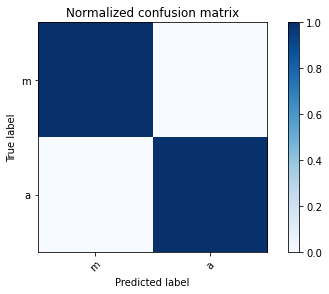

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, 'masked', rotation=45)
    plt.yticks(tick_marks, 'masked')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(valid.target.values , valid.predictions.values)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')


# MTCNN to detect human faces 